In [1]:
import argschema
import os
import numpy as np
from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndimage
from argschema.fields import Str, Float
import matplotlib.pyplot as plt
import tensorstore as ts

# add the path to the module
import sys
sys.path.append('/home/wanqing.yu/AC_Project/packages/axonal_connectomics/')
from acpreprocessing.utils import io, convert

def ndfilter(img,sig=3):
    img = ndimage.gaussian_filter(img, sigma=(sig, sig, 5), order=0)
    return img

def flatten_bottom(img, bottom):
    """
    shift the height of each pixel to align the bottom of the section
    :param img: 3d array
    :param bottom: 2d array, int, indices of bottom surface
    :return imgb: 3d img, same size as img,
    """

    if len(img.shape) != 3:
        raise ValueError('input array should be 3d.')

    if bottom.shape != (img.shape[1], img.shape[2]):
        raise ValueError('the shape of top should be the same size as each plane in img.')

    imgb = np.zeros(img.shape, dtype=img.dtype)

    z, y, x = img.shape

    for yi in range(y):
        for xi in range(x):
            b = bottom[yi, xi]
            if b!= 0:
                col = img[:b, yi, xi]
                imgb[-len(col):, yi, xi] = col

    imgb = imgb[-np.amax(bottom):, :, :]

    return imgb


def flatten_top(img, top):
    """
    shift the height of each pixel to align the top of the section
    :param img: 3d array
    :param top: 2d array, int, indices of top surface
    :return imgft: 3d img, same size as img,
    """

    if len(img.shape) != 3:
        raise ValueError('input array should be 3d.')

    if top.shape != (img.shape[1], img.shape[2]):
        raise ValueError('the shape of top should be the same size as each plane in img.')

    imgt = np.zeros(img.shape, dtype=img.dtype)

    z, y, x = img.shape

    for yi in range(y):
        for xi in range(x):
            t = top[yi, xi]
            col = img[t:, yi, xi]
            imgt[:len(col), yi, xi] = col

    #imgt = imgt[-(z-np.amin(top)):, :, :]
    return imgt

def up_crossings(data, threshold=0):
    """
    find the index where the data up cross the threshold. return the indices of all up crossings (the onset data point
    that is greater than threshold, 1d-array). The input data should be 1d array.
    """
    if len(data.shape) != 1:
        raise ValueError('Input data should be 1-d array.')

    pos = data > threshold
    return (~pos[:-1] & pos[1:]).nonzero()[0] + 1

def down_crossings(data, threshold=0):
    """
    find the index where the data down cross the threshold. return the indices of all down crossings (the onset data
    point that is less than threshold, 1d-array). The input data should be 1d array.
    """
    if len(data.shape) != 1:
        raise ValueError('Input data should be 1-d array.')

    pos = data < threshold
    return (~pos[:-1] & pos[1:]).nonzero()[0] + 1

def find_surface(img, surface_thr, top_buffer = 0, bot_buffer = 0, is_plot=True):
    """
    :param img: 3d array, ZYX, assume small z = top; large z = bottom
    :param surface_thr: [0, 1], threshold for detecting surface
    :return top: 2d array, same size as each plane in img, z index of top surface
    :return bot: 2d array, same size as each plane in img, z index of bottom surface
    """

    if len(img.shape) != 3:
        raise ValueError('input array should be 3d.')

    z, y, x = img.shape
    top = np.zeros((y, x), dtype=int)
    bot = np.ones((y, x), dtype=int) * z

    for yi in range(y):
        for xi in range(x):
            curr_t = img[:, yi, xi]
            mx = curr_t.max()
            mn = curr_t.min()
            
            if mx != mn:
                curr_t = (curr_t - mn) / (mx - mn)

                if curr_t[0] < surface_thr:
                    curr_top = up_crossings(curr_t, surface_thr)
                    curr_top = curr_top + top_buffer
                    if len(curr_top) != 0:
                        top[yi, xi] = curr_top[0]

                if curr_t[-1] < surface_thr:
                    curr_bot = down_crossings(curr_t, surface_thr)
                    curr_bot = curr_bot+bot_buffer
                    if len(curr_bot) != 0:
                        bot[yi, xi] = curr_bot[-1]
                        
    return top, bot

In [2]:
###added codec parameter
def create_tensor(fpath, arr_shape, driver='zarr3', store='file', dtype='float32', fill_value=-np.inf, 
                       chunk_shape=(64, 64, 64), res=[1,1,1], scale=0, arr=None, AWS_param=None, encoding='raw', codec=None):
    """Create a tensorstore object, with optional setting of array
       driver: Type of file, including zarr, n5, precomputed
       store: Type of source, including file, in-memory, s3
       AWS Key, AWS_Secret_Key: Only applicable to s3 store
    """
    if 'int' in str(dtype):
        fill_value=0
    if isinstance(arr, np.ndarray):
        arr = arr.astype(dtype)
    kvstore = {"driver": store,"path": fpath}
    if store == 's3':
        bucket,path = split_s3_path(fpath)
        kvstore = {"driver": "s3","bucket": bucket ,"path": path}
        if AWS_param:
            kvstore.update({"aws_region": AWS_param.region})
            if hasattr(AWS_param, "endpoint_url"):
                kvstore.update({"endpoint": AWS_param.endpoint_url})
            cred = {"aws_credentials":{"profile": AWS_param.profile}}
            if hasattr(AWS_param, "credential_file"):
                cred = {"aws_credentials":{"profile": AWS_param.profile, 
                                           "filename": AWS_param.credential_file['filename']}}
            kvstore.update(cred)

    if driver in ['zarr','zarr3','n5']:
        fill_value=None if driver=='n5' else fill_value
        dic = {'driver': driver,'kvstore': kvstore}
        if codec:
            dic.update(codec)
        out_arr = ts.open(dic,
         dtype=dtype,
         fill_value=fill_value,
         chunk_layout=ts.ChunkLayout(chunk_shape=chunk_shape),
         create=True,
         shape=list(arr_shape)).result()

    if driver == 'neuroglancer_precomputed':
        arr_shape=list(arr_shape)+[1] if len(arr_shape)==3 else arr_shape
        out_arr = ts.open(
                    {
                        "driver": "neuroglancer_precomputed",
                        "kvstore": kvstore,
                        "scale_metadata": {
                            "resolution": res,
                            "chunk_size": list(chunk_shape),
                            "encoding": encoding,
                            "key": "s" + str(scale)
                        },
                    'delete_existing' : True,
                    },
                    create=True,
                    dtype=dtype,
                    domain=ts.IndexDomain(
                        shape=list(list(arr_shape)),
                    )).result()

    if isinstance(arr, np.ndarray):
        out_arr.write(arr).result()

    return out_arr

def open_tensor(fpath, driver='zarr3', store='file', AWS_param=None, bytes_limit= 100_000_000, codec=None):
    """Open a tensorstore object.
       driver: Type of file, including zarr, n5, precomputed
       store: Type of source, including file, s3
       AWS_client: Only applicable to s3 store
    """
    kvstore = {"driver": store,"path": fpath}
    if store == 's3':
        bucket,path = split_s3_path(fpath)
        kvstore = {"driver": "s3","bucket": bucket ,"path": path}
        if AWS_param:
            kvstore.update({"aws_region": AWS_param.region})
            if hasattr(AWS_param, "endpoint_url"):
                kvstore.update({"endpoint": AWS_param.endpoint_url})
            cred = {"aws_credentials":{"profile": AWS_param.profile}}
            if hasattr(AWS_param, "credential_file"):
                cred = {"aws_credentials":{"profile": AWS_param.profile, 
                                           "filename": AWS_param.credential_file['filename']}}
            kvstore.update(cred)
    #Load tensorstore array
    dic = {
         'driver':
             driver,
         'kvstore': kvstore,
     # Use 100MB in-memory cache.
         'context': {
             'cache_pool': {
                 'total_bytes_limit': bytes_limit
             }
         },
         'recheck_cached_data':'open'}
    if codec:
        dic.update(codec)
    dataset_future = ts.open(dic)
    return dataset_future.result()

In [3]:
def create_mask(top, bottom, shape):
    """
    :param top: 2d array, int, indices of top surface
    :param bottom: 2d array, int, indices of bottom surface
    :param shape: 3d tuple, dimensions of array, ZYX
    :return bot: 2d array, same size as each plane in img, z index of bottom surface
    """
    total = 0
    mask = np.zeros(shape).astype('uint32')
    for y in range(shape[1]):
        for x in range(shape[2]):
            zmin,zmax = top[y][x], bottom[y][x]
            total += zmax-zmin
            mask[zmin:zmax,y,x] = 1
    
    print("% Pixels Masked:",100-(total/(shape[0]*shape[1]*shape[2]))*100)
    return mask

In [21]:
#Open image data and transpose
stack = open_tensor("/ACdata/Users/kevin/ispim_ome_zarr/H17_x55_S32_230412_highres/H17_x55_S32_230412_highres.zarr/highres_Pos40/1/", 
                    bytes_limit= 100_000_000, driver='zarr')
stack = stack[0,0,12000:15000,:,:].transpose().read().result()

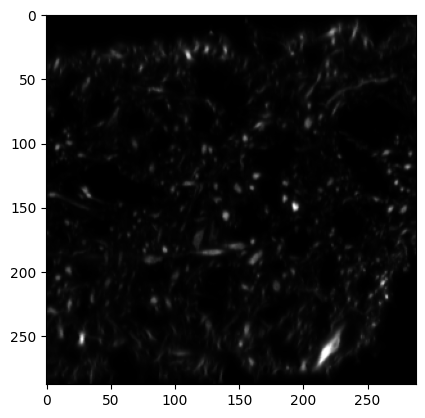

In [24]:
plt.imshow(stack[:,:,5], cmap='gray')

In [33]:
#find image surfaces and create mask
top,bottom = find_surface(stack, .1, is_plot=True)
mask = create_mask(top,bottom,(stack.shape)).transpose()

% Pixels Masked: 41.36897987397119


In [4]:
#Open image data and transpose
stack_test = open_tensor("/ACdata/Users/kevin/exaspim_ome_zarr/output_exa4/test.zarr/tile_x_0002_y_0001_z_0000_ch_488/4/", 
                    bytes_limit= 100_000_000, driver='zarr')
stack_test = stack_test[0,0,:,:,:].read().result()

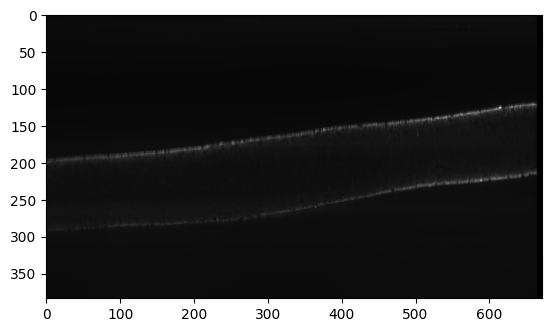

In [5]:
plt.imshow(stack_test[:,:,0], cmap='gray')

In [6]:
#find image surfaces and create mask
top_test,bottom_test = find_surface(stack_test, .1, is_plot=True)

In [7]:
from scipy.ndimage import median_filter
top_smooth = median_filter(top_test, size=25)
bottom_smooth = median_filter(bottom_test, size=25)

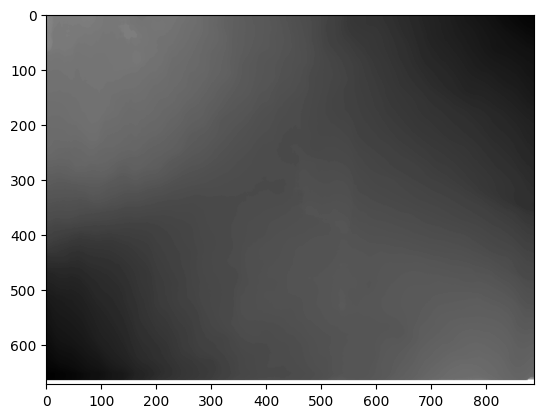

In [8]:
plt.imshow(top_smooth, cmap='gray')
plt.imshow(bottom_smooth, cmap='gray')

In [9]:
mask_test = create_mask(top_smooth,bottom_smooth,(stack_test.shape))

% Pixels Masked: 72.69757943280892


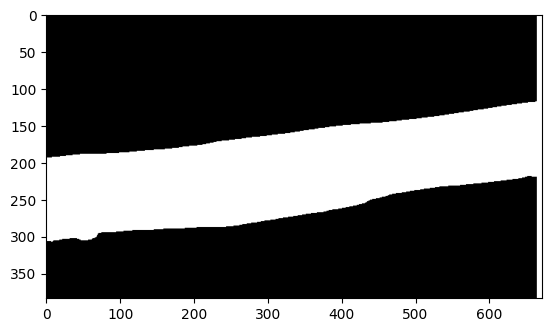

In [10]:
plt.imshow(mask_test[:,:,0], cmap='gray')

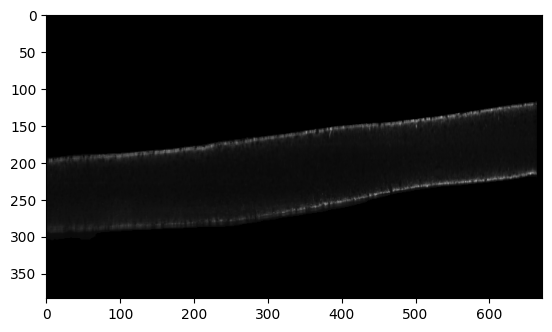

In [11]:
# masked stack
masked_stack = stack_test * mask_test
plt.imshow(masked_stack[:,:,5], cmap='gray')

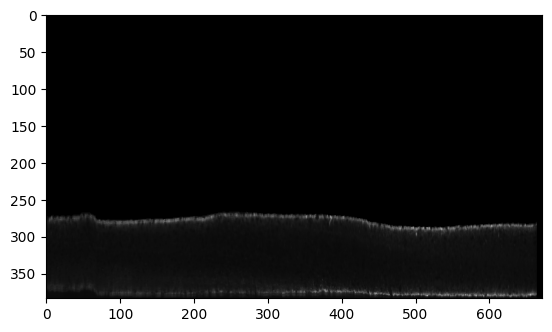

In [12]:
data_flatB = flatten_bottom(masked_stack, bottom_smooth)
plt.imshow(data_flatB[:,:,5], cmap='gray')

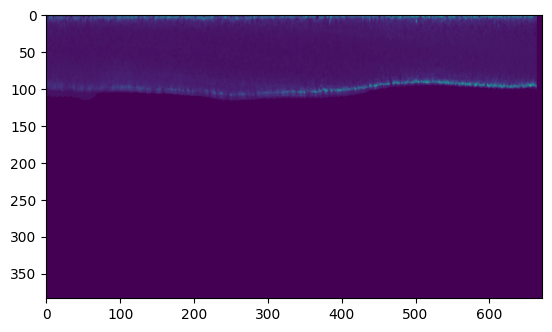

In [16]:
data_flatT = flatten_top(masked_stack, top_smooth)
plt.imshow(data_flatT[:,:,5])

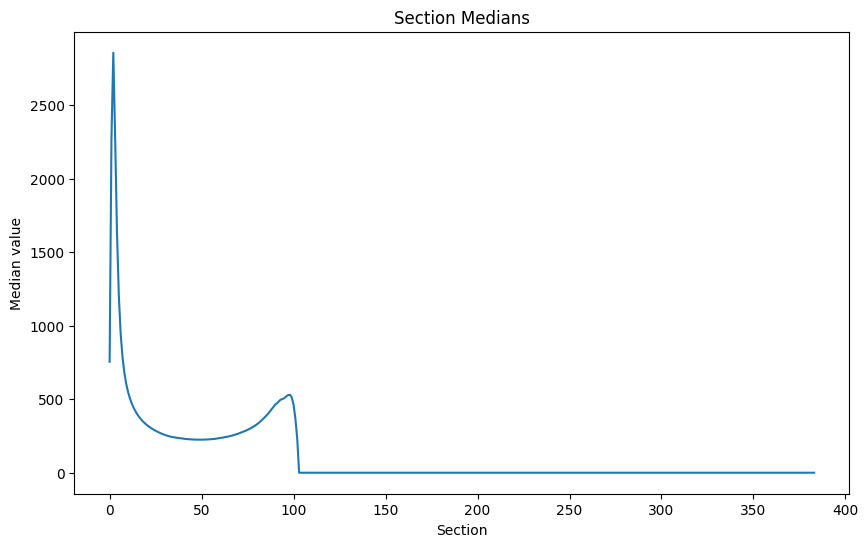

In [15]:
flatT_medians = np.median(data_flatT, axis=(1,2))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(flatT_medians)
plt.title('Section Medians')
plt.xlabel('Section')
plt.ylabel('Median value')
plt.show()

In [ ]:
# write masked stack to tiff


In [20]:
#create mask zarr
ts_mask = create_tensor("/home/connor.laughland/Documents/Other/mask.zarr", arr_shape=mask.shape, dtype='uint32', 
                  codec={"metadata": {"codecs": [{"name": "blosc", "configuration": {"cname": "lz4", "clevel": 5}}]}})
ts_mask.write(mask).result()